In [2]:
import json

data_path = '../angebot_data'

with open(data_path+'/result.json', 'r') as f:
  angebot = json.load(f)

In [3]:
from datasets import load_dataset
from PIL import Image,ImageDraw
import json

/home/tomislav/miniconda3/envs/angebot_ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
angebot['categories']

[{'id': 0, 'name': 'discount'},
 {'id': 1, 'name': 'price'},
 {'id': 2, 'name': 'product area'},
 {'id': 3, 'name': 'product name'}]

In [5]:
def transform_result(result,img_id,exclude_classes=[]):

    annotations = [r for r in result['annotations']
                   if r['image_id'] == img_id
                   if r['category_id'] not in exclude_classes
                   ]
    new_result = {
        'image_id':img_id,
        'image': Image.open(data_path+'/'+result['images'][img_id]['file_name']),
        'width':result['images'][img_id]['width'],
        'height':result['images'][img_id]['height'],
        'objects':{
            'id':[a['id'] for a in annotations],
            'area':[a['area'] for a in annotations ],
            'bbox':[a['bbox'] for a in annotations ],
            'category':[a['category_id'] for a in annotations],
        }
    }


    return new_result

In [22]:
def find_inside_boxes(dataset_row, core_bbox):
    bbox = (core_bbox[0], core_bbox[1], core_bbox[0]+core_bbox[2], core_bbox[1]+core_bbox[3])
    img = dataset_row['image'].crop(bbox)
    inside_bboxes_and_classes = [([b[0]-bbox[0], b[1] - bbox[1], (b[0]+b[2]) - bbox[0],  (b[1]+b[3]) - bbox[1]],c)
                     for b,c in zip(dataset_row['objects']['bbox'], dataset_row['objects']['category'])
                     if b[0] >= bbox[0] and b[1] >= bbox[1] and b[0]+b[2] <= bbox[2] and b[1]+b[3] <= bbox[3] and c != 2]
    inside_boxes = []
    for inside_bboxes,_ in inside_bboxes_and_classes:
      temp_bbox = [b for b in inside_bboxes]
      if inside_bboxes[0]+ inside_bboxes[2] > img.width:
        temp_bbox[2] = img.width - temp_bbox[0]
      if inside_bboxes[1]+ inside_bboxes[3] > img.height:
        temp_bbox[3] = img.height - temp_bbox[1]
      inside_boxes.append(temp_bbox)
    return inside_boxes, [inside_classe for _,inside_classe in inside_bboxes_and_classes], img


def handle_row(dataset_row):
    core_bboxes = [bbox
               for bbox,category in zip(dataset_row['objects']['bbox'], dataset_row['objects']['category'])
               if category == 2]
    inside_bboxes_all = []
    inside_classes_all = []
    img_all = []
    for core_bbox in core_bboxes:
        inside_bboxes, inside_classes, img = find_inside_boxes(dataset_row, core_bbox)
        inside_bboxes_all.append(inside_bboxes)
        inside_classes_all.append(inside_classes)
        img_all.append(img)

    return [
        {
            #'image_id': f"{dataset_row['image_id']}_{img_id}",
            'image_id': int(f"{dataset_row['image_id']}0{img_id}"),
            'image':img,
            'width': img.width,
            'height': img.height,
            'objects': {
                'bbox': inside_bboxes,
                'category': inside_classes,
                'id':[i for i in range(len(inside_classes))],
                'area':[bbox[2]*bbox[3] for bbox in inside_bboxes]
            },
        }
        for img_id,(inside_bboxes, inside_classes, img) in enumerate(zip(inside_bboxes_all, inside_classes_all, img_all))
    ]


In [23]:
from datasets import load_dataset
from datasets import Dataset

angebot_dataset = Dataset.from_list([transform_result(angebot,i,[]) for i in range(len(angebot['images']))])
angebot_dataset = Dataset.from_list(
    [sub_row
     for row in angebot_dataset
     for sub_row in handle_row(row)]
)

In [24]:
ab_ds = angebot_dataset.train_test_split(test_size=0.2,seed = 420)

Width 390.8432642487047 497
Height 81.80440414507802 506
Width 497.0 497
Height 278.74093264248734 506
Width 497.0 497
Height 118.16191709844577 506


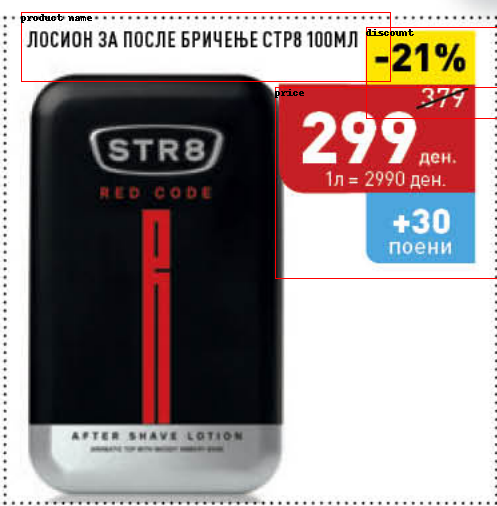

In [25]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = ab_ds["train"][0]["image"]
annotations = ab_ds["train"][0]["objects"]
draw = ImageDraw.Draw(image)


id2label = {r['id']:r['name'] for r in angebot['categories']}
label2id = {r['name']:r['id'] for r in angebot['categories']}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    print('Width',x+w,image.width)
    print('Height',y+h,image.height)
    draw.rectangle((x, y, x+w, y+h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="black")

image

In [10]:
from transformers import AutoImageProcessor

checkpoint = f"../model_data/300_epochs_subimages"
number_epochs = 50
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [11]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [12]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [13]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [14]:
ab_ds["train"] = ab_ds["train"].with_transform(transform_aug_ann)

In [15]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [ ]:
from transformers import AutoModelForObjectDetection
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/Angebot/facebook-detr-resnet-50/300_epochs_subimages",
    per_device_train_batch_size=8,
    num_train_epochs=number_epochs,
    fp16=True,
    save_strategy='no',
    logging_strategy='epoch',
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    #push_to_hub=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ab_ds["train"],
    tokenizer=image_processor,
)

In [ ]:
trainer.train()

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Step,Training Loss
109,0.136300
218,0.154800
327,0.149500
436,0.154600
545,0.151000
654,0.146600
763,0.150600
872,0.149700
981,0.145400
1090,0.144200


TrainOutput(global_step=5450, training_loss=0.1261468225881594, metrics={'train_runtime': 7176.7353, 'train_samples_per_second': 6.04, 'train_steps_per_second': 0.759, 'total_flos': 2.0713186600128012e+19, 'train_loss': 0.1261468225881594, 'epoch': 50.0})

In [ ]:
trainer.save_model()

In [ ]:
STOP

NameError: ignored

In [16]:
latest_model_check_path = f"../model_data/300_epochs_subimages"

In [17]:
from transformers import AutoImageProcessor
from transformers import AutoModelForObjectDetection

im_processor = AutoImageProcessor.from_pretrained(latest_model_check_path)
model = AutoModelForObjectDetection.from_pretrained(latest_model_check_path)

model.safetensors: 100%|██████████| 102M/102M [00:09<00:00, 11.4MB/s] 


In [18]:
import json


# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/cppe5/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

In [26]:
import torchvision
from transformers import AutoImageProcessor
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained(latest_model_check_path)

path_output_ab_ds, path_anno = save_cppe5_annotation_file_images(ab_ds["test"])
test_ds_coco_format = CocoDetection(path_output_ab_ds, im_processor, path_anno)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [27]:
import evaluate
from tqdm import tqdm
import torch

model = AutoModelForObjectDetection.from_pretrained(latest_model_check_path)
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

  0%|          | 0/28 [00:00<?, ?it/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
`post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.
100%|██████████| 28/28 [09:16<00:00, 19.86s/it]


Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

In [28]:
import json
with open(f'{latest_model_check_path}/results.json','w') as f:
  f.write(json.dumps(results))


In [29]:
latest_model_check_path

'../model_data/300_epochs_subimages'

In [41]:
from transformers import pipeline
import requests
import os
from PIL import Image
from PIL import ImageDraw

img_path = "cropped_image4.png"
image = Image.open(img_path)
latest_model_check_path = f"../model_data/300_epochs_subimages"

obj_detector = pipeline("object-detection", model=latest_model_check_path)
bbx_info = obj_detector(image)

In [42]:
def draw_bbx_on_in_mem_img(img,bbx_info):
  draw = ImageDraw.Draw(img)
  for bb in bbx_info:
    label = bb['label']
    score = bb['score']
    box = bb['box']
    x,y,w,h = box['xmin'],box['ymin'],box['xmax'],box['ymax']
    draw.rectangle((x, y, w, h), outline="red", width=1)
    draw.text((x, y), f'{label} Score: {score}', fill="black")

  return img

In [43]:
bbx_image = draw_bbx_on_in_mem_img(image,bbx_info)
bbx_image.save('bbx_image4.png')

In [73]:
img = angebot_dataset[150]['image']
obj_detector = pipeline("object-detection", model=latest_model_check_path)
bbx_info = obj_detector(img)
bbx_info

[{'score': 0.9978768825531006,
  'label': 'price',
  'box': {'xmin': 0, 'ymin': 192, 'xmax': 198, 'ymax': 355}},
 {'score': 0.9742715954780579,
  'label': 'product name',
  'box': {'xmin': 0, 'ymin': 25, 'xmax': 238, 'ymax': 207}}]

In [74]:
bbx_info = [bbx for bbx in bbx_info if bbx['score']> 0.9]
bbx_info

[{'score': 0.9978768825531006,
  'label': 'price',
  'box': {'xmin': 0, 'ymin': 192, 'xmax': 198, 'ymax': 355}},
 {'score': 0.9742715954780579,
  'label': 'product name',
  'box': {'xmin': 0, 'ymin': 25, 'xmax': 238, 'ymax': 207}}]

In [5]:
img = draw_bbx_on_in_mem_img(img,bbx_info)
img

NameError: name 'img' is not defined

In [77]:
img.save('test.png')

In [ ]:
def draw_bbx_on_img(img_path,bbx_info):
  image = Image.open(img_path)
  draw = ImageDraw.Draw(image)
  for bb in bbx_info:
    label = bb['label']
    score = bb['score']
    box = bb['box']
    x,y,w,h = box['xmin'],box['ymin'],box['xmax'],box['ymax']
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), f'{label} Score: {score}', fill="black")

  return image

In [ ]:
def check_for_results(img_path,model):
  img_path = img_path
  image = Image.open(img_path)

  obj_detector = pipeline("object-detection", model=model)
  objects = obj_detector(image)
  return True if len(objects)>0 else False